## Script to create and train a variational auto-encoder (VAE).

In [ ]:
## If using google colab

#from google.colab import drive
#drive.mount('/content/drive')

# Path to the Brain images dataset numpy array (example: "/content/drive/MyDrive/GroovyBrain/images_numpy/train_images.npy")
file_path = ""

# Path to save trained model weights (example: "/content/drive/MyDrive/GroovyBrain/trained_model/groovy_brain_trained_vae.pth")
save_trained_model_path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch import nn, optim
from model import VariationalAutoEncoder
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Class for creating custom dataset
class CustomDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = np.load(file_path)
        self.transform = transform

        # Normalize data to range [0, 1]
        self.data = self.data / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create your custom dataset
custom_dataset = CustomDataset(file_path, transform=transform)
train_dataset = custom_dataset

# Define your batch size
BATCH_SIZE = 32

# Create a data loader
train_loader = DataLoader(dataset=custom_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Define VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super(VariationalAutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 32x32 output
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16 output
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8 output
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 4x4 output
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 output
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 output
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 output
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 64x64 output
            nn.Sigmoid()  # Sigmoid to get pixel values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var


In [ ]:
# Set device if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load your custom dataset
train_images = np.load(file_path)
train_images = train_images.astype(np.float32) / 255.0  
train_images = np.expand_dims(train_images, axis=1)  # Add channel dimension
train_images = torch.tensor(train_images)

# Define custom dataset and dataloader
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define VAE model
z_dim = 20  # Dimension of latent space
vae = VariationalAutoEncoder(z_dim).to(device)

# Define optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Loss function - reconstruction loss + KL divergence
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Training loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data,) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader.dataset):.4f}")

print('Finished Training')


100%|██████████| 266/266 [06:04<00:00,  1.37s/it]


Epoch 1, Loss: 1711.2345


100%|██████████| 266/266 [06:01<00:00,  1.36s/it]


Epoch 2, Loss: 1551.6984


100%|██████████| 266/266 [06:08<00:00,  1.39s/it]


Epoch 3, Loss: 1525.9205


100%|██████████| 266/266 [06:18<00:00,  1.42s/it]


Epoch 4, Loss: 1517.4640


100%|██████████| 266/266 [06:16<00:00,  1.41s/it]


Epoch 5, Loss: 1509.5151


100%|██████████| 266/266 [06:14<00:00,  1.41s/it]


Epoch 6, Loss: 1501.3412


100%|██████████| 266/266 [06:22<00:00,  1.44s/it]


Epoch 7, Loss: 1497.5155


100%|██████████| 266/266 [06:17<00:00,  1.42s/it]


Epoch 8, Loss: 1494.5027


100%|██████████| 266/266 [06:15<00:00,  1.41s/it]


Epoch 9, Loss: 1492.3051


100%|██████████| 266/266 [06:15<00:00,  1.41s/it]

Epoch 10, Loss: 1490.6988
Finished Training


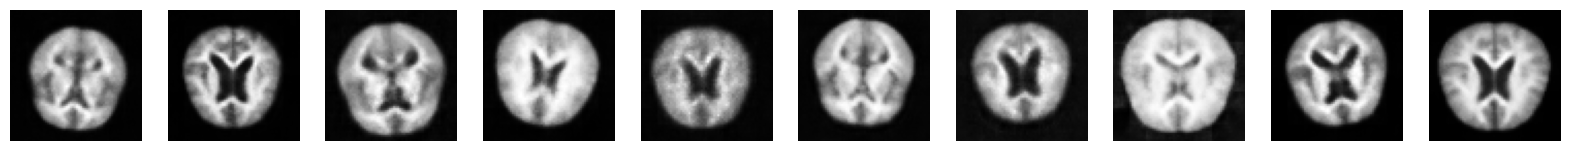

In [ ]:
# Plot 10 example images

# Generate 10 random latent vectors
latent_vectors = torch.randn(10, z_dim).to(device)

# Decode the latent vectors to generate images
vae.eval()  # Switch to evaluation mode
with torch.no_grad():
    generated_images = vae.decode(latent_vectors).cpu()

# Plot the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.show()


In [ ]:
# Save the trained model
torch.save(vae.state_dict(), save_trained_model_path)